## Time Series - Part3 - ARIMA
1.	Import libraries & set directory paths
2.	Import dataset and check dimensions and columns.
    -	Import: time_series_requests_7day_MA_from_Jun2020_Diff(1).csv
3.	Convert date column from string to date & check min and max dates.
4.	Convert dataframe to time series
5.	Time series decomposition
6.	Test for Stationarity
    -	Dickey-Fuller Test
    -	Autocorrelation
7.	Forecasting using ARIMA model
    -	Determine value for p (AR) by plotting PACF
    -	Determine value for q (MA) y plotting ACF
8.	Split the data into training and test sets
9.	Run and fit the ARIMA model
    -	Import functions
    -	Define parameters etc.
    -	Interpret results
    -	Display as plot.
    -	Repeat as necessary
  
In Summary: The data collected for Stone Signs' business since January 2020 has seen three pandemic related lockdowns, plus a housing market incentive which has resulted in a set of very inconsistent data points making it very difficult to provide predictions.

### import libraries

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# The use of .api also import the public access versin of statsmodels
# statsmodels handles statistical models
import statsmodels.api as sm

# Import warnings & disable deprecation warnings that could indicate, for instance, a suspended library or feature. 
    # These are more relevant to developers and very seldom to analysts.
import warnings
warnings.filterwarnings("ignore")

import quandl

# 'fivethirtyeight' is a styling option for how your plots will appear.
    # More examples:
    # https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
    # https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html
plt.style.use('fivethirtyeight')

### set directory paths

In [2]:
dataset = r'D:\My Documents\! Omnicompetent Ltd\Career Foundry - Data Analytics\Data Analytics Course\60 Advanced Analytics and Dashboard Design\Stone Signs Portal Analysis\02 Data'
dataset

'D:\\My Documents\\! Omnicompetent Ltd\\Career Foundry - Data Analytics\\Data Analytics Course\\60 Advanced Analytics and Dashboard Design\\Stone Signs Portal Analysis\\02 Data'

In [3]:
vizpath = r'D:\My Documents\! Omnicompetent Ltd\Career Foundry - Data Analytics\Data Analytics Course\60 Advanced Analytics and Dashboard Design\Stone Signs Portal Analysis\04 Analysis'
vizpath

'D:\\My Documents\\! Omnicompetent Ltd\\Career Foundry - Data Analytics\\Data Analytics Course\\60 Advanced Analytics and Dashboard Design\\Stone Signs Portal Analysis\\04 Analysis'

## Import Time Series data
7 Day Moving Avergae with one round of Differencing

In [4]:
df_request_7ma = pd.read_csv(os.path.join(dataset,'time_series_requests_7day_MA_from_Jun2020_Diff(1).csv'))
df_request_7ma.head()

,date,MA
0,2020-06-07,0.000000
1,2020-06-08,-1.000000
2,2020-06-09,-2.571429
3,2020-06-10,-0.857143
4,2020-06-11,-0.571429


### check dimensions & data types

In [5]:
df_request_7ma.shape

(451, 2)

In [6]:
df_request_7ma.dtypes

date     object
MA      float64
dtype: object

### convert date column from string to date format

In [7]:
df_request_7ma['date'] = pd.to_datetime(df_request_7ma['date'], format='%Y-%m-%d')

In [8]:
df_request_7ma.dtypes

date    datetime64[ns]
MA             float64
dtype: object

### check min and max values for request_date
    to ensure conversion carried out correctly

In [9]:
df_request_7ma['date'].min()

Timestamp('2020-06-07 00:00:00')

In [10]:
df_request_7ma['date'].max()

Timestamp('2021-08-31 00:00:00')

### convert to time series by setting the 'date' as the index

In [12]:
df_request_7ma = df_request_7ma.set_index(['date'])
df_request_7ma.head()

,MA
date,
2020-06-07,0.000000
2020-06-08,-1.000000
2020-06-09,-2.571429
2020-06-10,-0.857143
2020-06-11,-0.571429


In [13]:
df_request_7ma.tail()

,MA
date,
2021-08-27,-1.714286
2021-08-28,0.857143
2021-08-29,0.000000
2021-08-30,-7.285714
2021-08-31,-1.571429


### check for nulls

In [14]:
df_request_7ma.isnull().sum()

MA    0
dtype: int64

## Display as time series plot

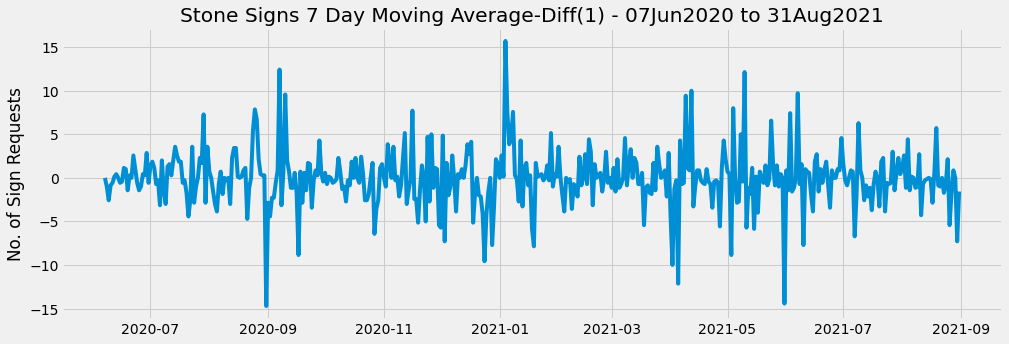

In [36]:
plt.figure(figsize=(15,5))
plt.title('Stone Signs 7 Day Moving Average-Diff(1) - 07Jun2020 to 31Aug2021')
plt.ylabel('No. of Sign Requests')
plt.plot(df_request_7ma)

plt.savefig(os.path.join(vizpath,'01a Time Series - 7 Day Moving Average-Diff(1) - 07Jun2020 to 31Aug2021.png'))

### review dickey fuller test on differenced data
1.   Import function
2.   Create definition
3.   Run test
4.   Interpret results

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])

    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

In [18]:
dickey_fuller(df_request_7ma['MA'])

Dickey-Fuller Stationarity test:
Test Statistic                -9.286372e+00
p-value                        1.212380e-15
Number of Lags Used            1.300000e+01
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


Interpreting Dickey-Fuller Results:
- If p-value > 0.05  -->  H0 - Fail to Reject H0
- If p-value < 0.05  -->  Ha - Reject Null Hypothesis


- If Test Statistic > Critial Value  -->  Fail to Reject H0
- If Test Statistic < Critial Value  -->  Reject the Null Hypothesis


- The more negative the Test Statitic; the stronger the rejection of H0.

#### DF Results:
- p-value: 0.00000000000000121 < alpha: 0.05 = Ha
- Test Statistic: -9.28 < Critial Value: -2.86 = Ha

The above results mean that H0 can be rejected in favour of Ha, meaning that the data does not contain a Unit Root and is therefore considered Stationary.

### review autocorrelation on differenced data
1.   Import functions
2.   Generate plot

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [20]:
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

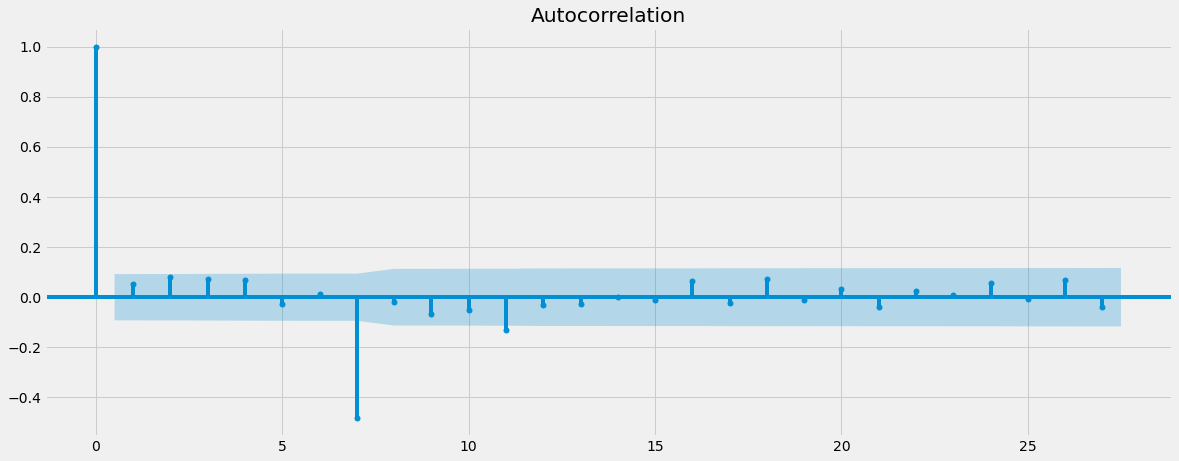

In [22]:
plot_acf(df_request_7ma)
plt.savefig(os.path.join(vizpath,'01b Time Series - 7 Day MA Autocorrelation Test1 on Diff(1).png'))

The above plot shows all but 2 lags inside the Confidence Interval.

## Forecasting using ARIMA Model

The parameters ARIMA(p,d,q):
- p = AR - number of data points to use - Plot PACF to make starting estimate number.
- d = number of rounds required to make the data stationary, for this time-series d=1.
- q = MA - number of error terms to use - Plot ACF to make starting estimate number.

Start with low numbers and apply to the training data.  Adjust according to the outcome of the test data.

### plot PACF - partial autocorrelation to determine a value for p

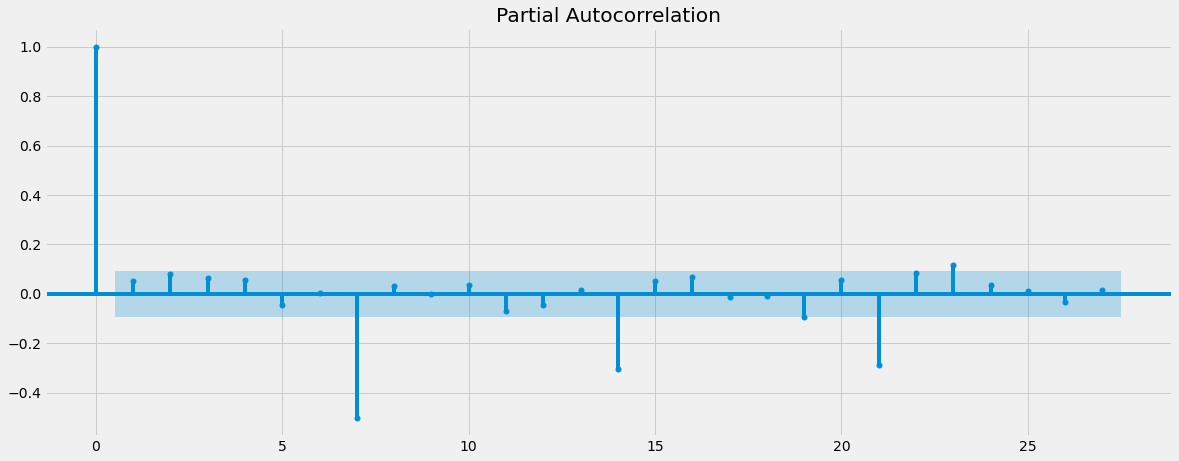

<Figure size 4500x4500 with 0 Axes>

In [23]:
plot_pacf(df_request_7ma)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

The number of significant positive correlations is 5.  Start with p=4

### plot ACF - autocorrelation to determine a value for q

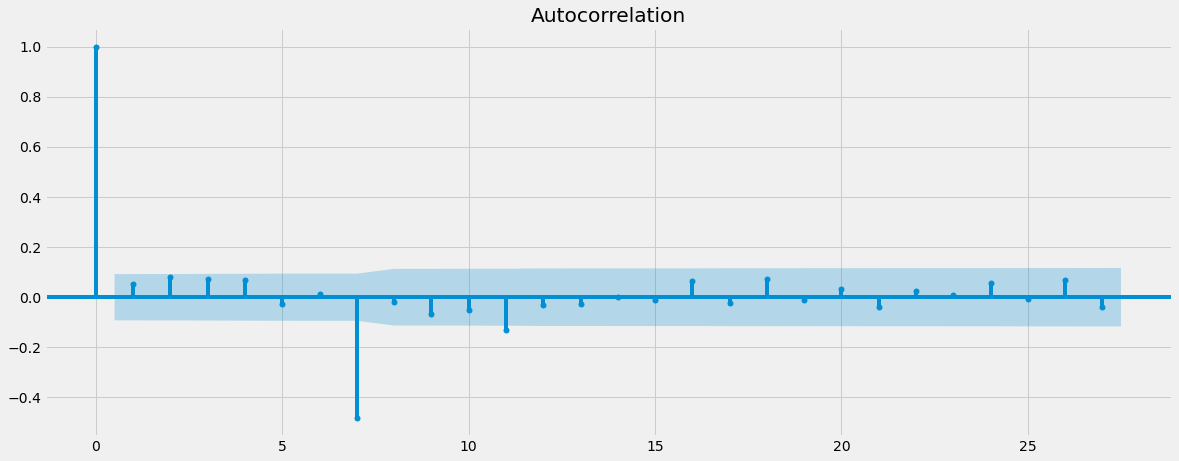

<Figure size 1500x500 with 0 Axes>

In [24]:
plot_acf(df_request_7ma)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

The number of significant correlations (lags outside the Confidence Interval (shaded area)) is 3.  Let q = 2.

Start Parameters are:
- p=4
- d=1
- q=2

### split the data into training and test sets keeping rows consecutive.
70:30 split

In [25]:
df_request_7ma.shape

(451, 1)

In [27]:
train = df_request_7ma['MA'][:316]
test = df_request_7ma['MA'][315:]

In [28]:
train.shape

(316,)

In [29]:
test.shape

(136,)

### show as plot

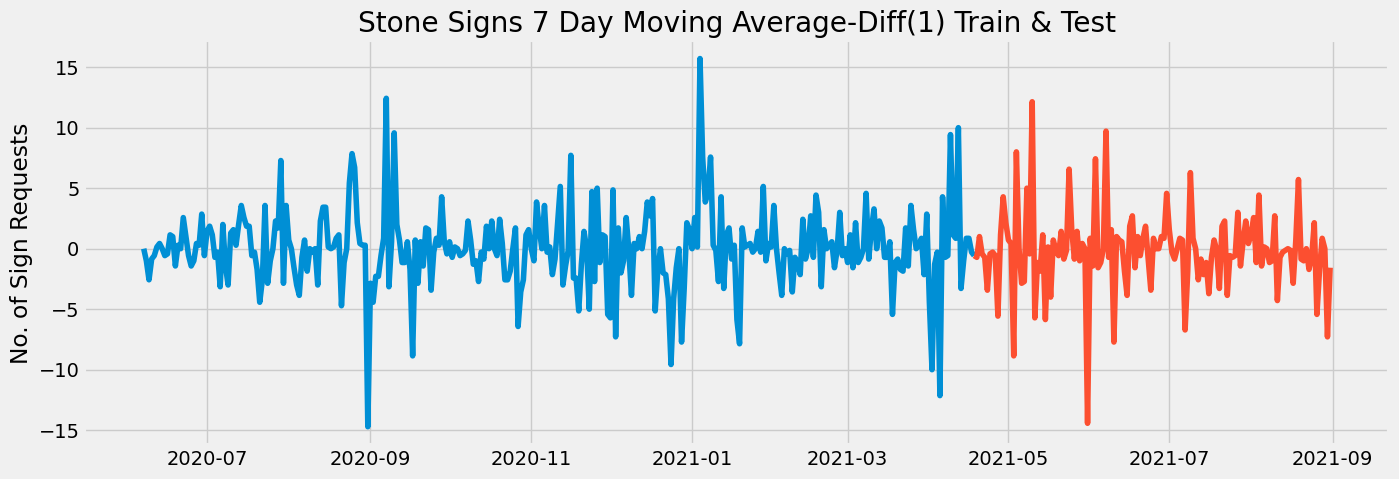

In [30]:
plt.figure(figsize=(15,5), dpi=100)
plt.title('Stone Signs 7 Day Moving Average-Diff(1) Train & Test')
plt.ylabel('No. of Sign Requests')

plt.plot(train)
plt.plot(test)

plt.savefig(os.path.join(vizpath,'02 Time Series - 7 Day MA-Diff(1) Train & Test.png'))

## Running and Fitting the ARIMA model

In [31]:
from statsmodels.tsa.api import ARIMA

In [32]:
model = ARIMA(train, order=(4, 1, 2))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(136, alpha=0.05)
# where 136 is the shape of the test set & alpha=0.05 is a 95% confidence interval 

# Make into pandas series & forecast curve
fc_series = pd.Series(fc, index=test.index)

# lower bound of the confidence interval
lower_series = pd.Series(conf[:, 0], index=test.index)

# Upper bound of the confidence interval
upper_series = pd.Series(conf[:, 1], index=test.index)

                             ARIMA Model Results                              
Dep. Variable:                   D.MA   No. Observations:                  315
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -804.835
Method:                       css-mle   S.D. of innovations              3.090
Date:                Fri, 12 Nov 2021   AIC                           1625.670
Time:                        05:49:22   BIC                           1655.691
Sample:                    06-08-2020   HQIC                          1637.664
                         - 04-18-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.071      0.944      -0.006       0.006
ar.L1.D.MA    -0.7277      0.076     -9.562      0.000      -0.877      -0.579
ar.L2.D.MA     0.1815      0.068      2.662      0.0

The Coefficient values in the column labeled 'coef' should ideally be <=0.05 representing the Level of Significant (alpha=0.05), or a Confidence Level of 95%.  3 ot of 7 do not meet this criteria.

### display as plot

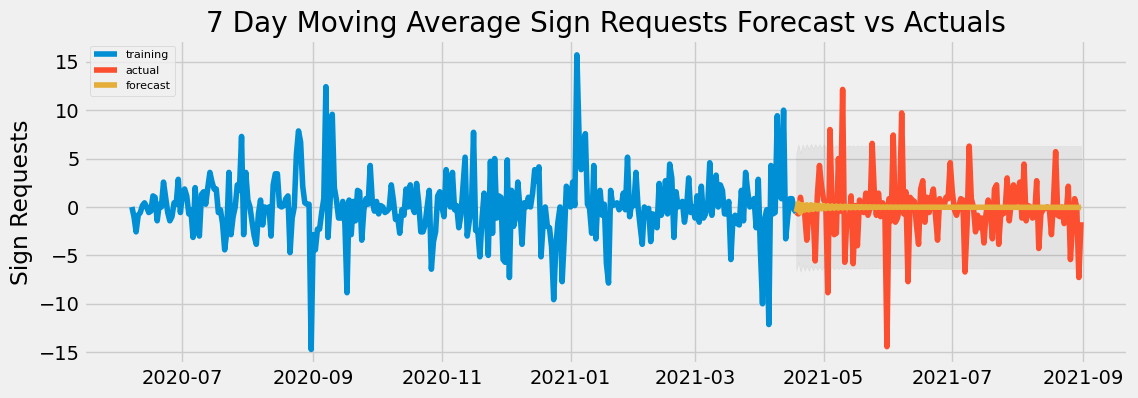

In [33]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('7 Day Moving Average Sign Requests Forecast vs Actuals')
plt.ylabel('Sign Requests')
plt.legend(loc='upper left', fontsize=8)
#plt.show()
plt.savefig(os.path.join(vizpath,'03 Time Series - 7 Day MA-Diff(1) Forecast.png'))

However, the forecast runs through the data points but the Confidence Interval (shaded area) does not capture all the data point.

### repeat ARIMA with the following parameters with 10% confidence level:
- p = 1
- d = 1
- q = 1

In [34]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(136, alpha=0.10)
# where 136 is the shape of the test set & alpha=0.05 is a 90% confidence interval 

# Make into pandas series & forecast curve
fc_series = pd.Series(fc, index=test.index)

# lower bound of the confidence interval
lower_series = pd.Series(conf[:, 0], index=test.index)

# Upper bound of the confidence interval
upper_series = pd.Series(conf[:, 1], index=test.index)

                             ARIMA Model Results                              
Dep. Variable:                   D.MA   No. Observations:                  315
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -815.015
Method:                       css-mle   S.D. of innovations              3.189
Date:                Fri, 12 Nov 2021   AIC                           1638.030
Time:                        05:51:23   BIC                           1653.041
Sample:                    06-08-2020   HQIC                          1644.028
                         - 04-18-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.117      0.907      -0.005       0.004
ar.L1.D.MA     0.1432      0.056      2.566      0.010       0.034       0.253
ma.L1.D.MA    -1.0000      0.008   -119.958      0.0

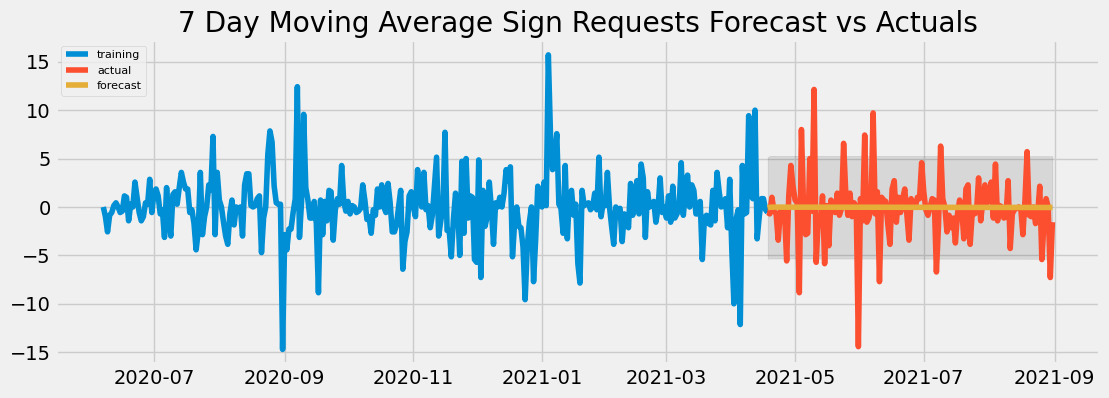

In [35]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=0.1) # This creates the confidence interval
plt.title('7 Day Moving Average Sign Requests Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
#plt.show()
plt.savefig(os.path.join(vizpath,'04 Time Series - 7 Day MA-Diff(1) Forecast.png'))

Depiste manipulation of the parameters and lowering the Confidence Level to 90%, it has not been possible to get the Coefficent values to <0.1 although they are fairly close.

#### In Summary:
The data collected for Stone Signs' business since January 2020 has seen three pandemic related lockdowns, plus a housing market incentive which has resulted in a set of very inconsistent data points making it very difficult to provide predictions.